# VaR of returns series and backtesting (multivariate) 
I use a **R-Vine copula** to model dependence and a **GJR-GARCH** with **skewed-t** errors for margins to estimate one-day ahead VaR of portfolio return series. Then, I evaluate this risk measure according to backtesting techniques.

## 1. Load and prepare the data

In [2]:
# libraires
library(pracma)
library(ggplot2)
library(VineCopula)

In [3]:
# Choose the assets that will be included in the dataset
stocks <- c("AAPL", "AMZN", "MSFT", "GOOGL", "BRK-A", "JPM")
datalist <- list() 
t1 <- as.integer(ISOdate(2016,1,17,hour=0))
t2 <- as.integer(ISOdate(2022,6,9,hour=0))

for (stock in stocks) {
    url <- paste("https://query1.finance.yahoo.com/v7/finance/download/",
                 stock,
                 "?period1=",
                 as.integer(t1),
                 "&period2=",
                 as.integer(t2),
                 "&interval=1d&events=history&includeAdjustedClose=true",
                 sep="")
    data <- read.csv(url)
    data['Date'] <- as.Date(data$Date)    
    datalist[[stock]] <- data.frame(date=data$Date,price=data$Adj.Close)
}

# Merge
prices <- data.frame(datalist[stocks[1]])
colnames(prices) <- c('date',stocks[1])
for (i in 2:length(datalist)) {
    temp <- datalist[[i]]
    colnames(temp) <- c('date', stocks[i])
    prices <- merge(prices,temp,by="date")
}
prices <- data.frame(prices)

# Compute log-returns:
genretdf <- function(pricesdf) {
  prices <- data.matrix(pricesdf)
  ret <- 100*(diff(log(prices[,2:ncol(prices)])))  
  date <- as.Date(pricesdf$date[-1]) 
  retdf <- data.frame(date,ret)
  return(retdf)
  }

retdf <- genretdf(prices)

tail(retdf)

,date,AAPL,AMZN,MSFT,GOOGL,BRK.A,JPM
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1604,2022-06-01,-0.08738184,1.219143,0.2020956,0.11420578,-0.9388944,-1.7700882
1605,2022-06-02,1.66715234,3.096592,0.7897559,3.22297133,0.6558236,1.5960106
1606,2022-06-03,-3.93185999,-2.550765,-1.6746564,-2.65474892,-1.0761940,-1.4037469
1607,2022-06-06,0.52140293,1.974656,-0.4714425,1.97057569,0.1602479,-0.3309167
1608,2022-06-07,1.74330472,-1.444798,1.3857064,0.28122855,0.6596470,0.2617533
1609,2022-06-08,-0.50560480,-1.490731,-0.7699280,0.03798015,-1.7544310,-1.6042611


## 2. ES (rolling window estimation)

### 2.1. Margins: GJR-GARCH
The most frequent procedure to estimate VaR (and ES) is to propose a parametric model, derive the VaR (or ES) implied by the parametric model, and then estimate the model parameters. In this exercise, I assume that returns $r_{i,t}$ follow a GJR-GARCH model with skewed-t errors, i.e., 
\begin{eqnarray} 
r_{i,t} &=& \mu_i + \sigma_{i,t} z_{i,t}\\ 
\sigma_{i,t}^2 &=&  \omega_i + \beta_i  \sigma_{i,t-1}^2 + \alpha_i (\sigma_{i,t-1} z_{i,t-1})^2 + \gamma_i (\sigma_{i,t-1} z_{t-1})^2 I_{\{z_{i,t-1}<0\}}
\end{eqnarray} where  
- $z_{i,t}$ is an i.i.d. random variable that follows a skewed-t of Hansen (1994) distribution, with degrees of freedom and asymmetry parameters  denoted by $2<\nu_i<\infty$ and $-1<\lambda_i<1$, respectively.
- $\mu_i$ denotes de unconditional mean.
- $\sigma_{i,t}^2$ corresponds to the conditional variance which describes a GJR-GARCH model.
- $I$ is an indicator function that takes the value of 1 if the inequality is satisfied and 0 otherwise.
- Positiveness restrictions: $\omega_i>0$, $\alpha_i\geq 0$, $\alpha_i+\gamma_i>0$ and $\beta_i\geq 0$. 
- Stationarity restriction:  $\alpha_i+\frac{1}{2}\gamma_i+\beta_i<1$.

For each stock, there are 7 parameters to be estimated, e.g., $\theta_i:=(\mu_i, \omega_i, \beta_i, \alpha_i, \gamma_i,\nu_i,\lambda_i)$.


### 2.2. Dependence: R-Vine copula
Consider the $d$-dimensional random vector $(z_{1},...,z_{d})\sim F$. By Sklar's theorem (1959), its joint distribution, $F$, can be expressed as  \begin{equation}F(z_{1},...,z_{d})=C(F_1(z_{1}),...,F_d(z_{d})|\theta^c), \end{equation} for some function $C:[0,1]^d\to [0,1]$  called copula. $\theta^c$ denotes the compula parameter set. All the information regarding the dependence structure in $F$ is contained in the copula function $C$.  Define $u_{i}:=F_{i}(z_{i})$. Then, if $F$ is continuous,  $C$ is the unique joint distribution of the random vector of dependent uniforms $\mathbf{u}=(u_{1},...,u_{d})'$. Furthermore, if $C$  and $F$ are both differentiable, it is possible to represent the joint density function $f$ as \begin{equation}f(z_1,...,z_d)=c(u_1,...,u_d|\theta^c)\prod_{i=1}^{d}f_i(z_i), \end{equation} where $f_i$ denotes the marginal pdf of $Z_i$ and the copula density, $c$, is given by 
\begin{equation} c(u_1,...,u_d|\theta^c)=\frac{\partial^d C(u_1,...,u_d|\theta^c) }{\partial u_1\partial u_2...\partial u_d}.\end{equation} 

In this exercise, I consider a parametric copula called R-Vine (R library: [`VineCopula`](https://cran.r-project.org/web/packages/VineCopula/index.html)). The notion of R-Vine copulas is deeply described by  Cooke and Kurowicka (2006), while Czado (2019) provides a practical guide to analyze dependent data with vine copulas.

### 2.3. Expected Shortfall 
Consider a portfolio conformed by $d$ stocks and let $w_i$ denote the proportion of the total investment invested in stock $i$, $i=1,...,d$. Then, the portfolio return at day $t$ would be given by \begin{equation}
r_{p,t}=w_1 r_{1,t} + ... +w_d r_{d,t}\end{equation}

For simplicity and to keep the focus in ES estimation, we consider here an equally-weighted portfolio, e.g., $w_i=\frac{1}{d}$ for $i=1,...,d$.

For a given $\alpha\in(0,1)$, the $\alpha$-level ES at time $t$ is defined as:
\begin{equation} 
ES_{p,t}(\alpha)=\mathbb{E}\left(r_{p,t}|r_{p,t}\leq\text{VaR}_{p,t}(\alpha)\right), \\
\end{equation}
where $\text{VaR}_{p,t}(\alpha)$ denotes the value-at-risk (e.g., $\alpha$-quantile) of  portfolio returns series at time $t$.

In this particular case, the is not an analytical expression to obtain $\text{ES}_{p,t}(\alpha)$. Thus, we use Monte Carlo simulations to approximate it by means of *conditional sampling* using the R-Vine copula and the GJR-GARCH with skewed-t errors. Specifically, we generate 100,000 scenarios of one-day ahead portfolio returns and compute the sample mean of those returns below its $\alpha$-quantile.

Some required helper functions:
* `skewtinv(p,nu,lambda)` computes $z=F^{-1}(p|\nu,\lambda)$, given $p,\nu,\lambda$.
* `GJRloglik(par, ret)` computes $-L_{z}(\theta)= -\sum_{t=1}^{T}\log(f(z_{t}))$, given par$:=\theta$ and ret$:=\{r_{t}\}_{t=1}^T$. The minus symbol is because we estimate parameters, $\theta$, by maximizing this likelihood, however, the optimizer that we use here, `fmincon`, is able to minimize functions only. So that, that minus symbol transform our maximization problem into a minimization one.
* `GJRout(par, ret)` computes $-L_{z}(\theta)$, $\{\log(f(z_{t})\}_{t=1}^T$, $\{z_{t}\}_{t=1}^T$, $\{\sigma^2_t\}_{t=1}^T$ and $\sigma_{t+1}$, given par$:=\theta$ and ret$:=\{r_{t}\}_{t=1}^T$.
* `skewtpdf(x, nu, lambda)` computes the skewed-t *pdf*, e.g., $f(x|\nu,\lambda)$, given $x,\nu,\lambda$.

In [4]:
skewtinv <- function(p, nu, lambda) {
# USAGE:
#   X=skewtinv(P,V,LAMBDA)
 
# INPUTS:
#   P      - Values to be inverted, P in [0,1]
#   nu     - kurtosis parameter
#   lambda - skewness parameter 
     
# OUTPUTS:
#   X      - Skewed T distributed random variables corresponding to P

# COMMENTS:
#   nu > 2
#   -.99 < lambda < .99  
    
# REFERENCE:
#   [1] Hansen (1994), Intl.Econ.Rev. (35)

c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
a <- 4*lambda*c*((nu-2)/(nu-1))
b <- sqrt(1 + 3*lambda^2 - a^2)
  
f1 <- which(p <  (1-lambda)/2)
f2 <- which(p >= (1-lambda)/2)

inv1 <- ((1-lambda)/b)*sqrt((nu-2)/nu)*qt(p[f1]/(1-lambda),nu) - a/b
inv2 <- ((1+lambda)/b)*sqrt((nu-2)/nu)*qt(0.5+1/(1+lambda)*(p[f2]-(1-lambda)/2),nu) - a/b

x <- rep(NaN,length(p))
x[f1] <- inv1
x[f2] <- inv2
return(x) 
}


GJRloglik <- function(par, ret) {
    # Mean: unconditional mean 
    # Errors distribution: skewed-t (Hansen, 1994)  
    TT <- length(ret)
    
    # Starting values:
    rbar <- mean(ret)
    condVar <- matrix(rep(0,TT),TT)
    epsi <- matrix(rep(0,TT),TT)
    z <- matrix(rep(0,TT),TT)
    condVar[1] <- mean((ret-rbar)^2)
    epsi[1] <- sqrt(condVar[1])
    z[1] <- 0
  
    # Unconditional mean:
    mu <- par[1]
  
    # Conditional variance:
    # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
    b0 <- par[2] # omega
    b1 <- par[3] # beta
    b2 <- par[4] # alpha
    b3 <- par[5] # gamma
    
    # GJR-GARCH(1,1) :
    for (t in 2 : TT)  {
      condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
      z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
      epsi[t] <- z[t]*sqrt(condVar[t]) 
    }
    sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )
    
    # Distribution parameters:
    a <- tail(par,2) 
    nu <- a[1] # degrees of freedom
    lambda <- a[2] # skewnes parameter
   
  
    # Log-likelihood
    logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
    c = exp(logc) 
    a <- 4*lambda*c*((nu-2)/(nu-1))
    logb <- 0.5*log(1 + 3*lambda^2 - a^2)
    b <- exp(logb)
    f1 <- which(z <  (-a/b))
    f2 <- which(z >= (-a/b))
    ll <- rep(NaN,length(z))
    ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(condVar[f1])
    ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(condVar[f2])
    ll[f1] <- ll1
    ll[f2] <- ll2 
    LL <- -(sum(ll[2:length(ll)]))
    
  return(LL)
}


GJRout <- function(par, ret) {
    # Mean: unconditional mean 
    TT <- length(ret)

    # Starting values:
    rbar <- mean(ret)
    condVar <- matrix(rep(0,TT),TT)
    epsi <- matrix(rep(0,TT),TT)
    z <- matrix(rep(0,TT),TT)
    condVar[1] <- mean((ret-rbar)^2)
    epsi[1] <- sqrt(condVar[1])
    z[1] <- 1

    # Unconditional mean:
    mu <- par[1]

    # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
    b0 <- par[2] # omega
    b1 <- par[3] # beta
    b2 <- par[4] # alpha
    b3 <- par[5] # gamma
  
    # GJR-GARCH(1,1) :
    for (t in 2 : TT)  {
      condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
      z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
      epsi[t] <- z[t]*sqrt(condVar[t]) 
    }
    sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )
  

    # shape parameters:
    a <- tail(par,2) 
    nu <- a[1] # degrees of freedom
    lambda <- a[2] # skewnes parameter
  

    # Log-likelihood
    logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
    c = exp(logc) 
    a <- 4*lambda*c*((nu-2)/(nu-1))
    logb <- 0.5*log(1 + 3*lambda^2 - a^2)
    b <- exp(logb)
    f1 <- which(z <  (-a/b))
    f2 <- which(z >= (-a/b))
    ll <- rep(NaN,length(z))
    ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(condVar[f1])
    ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(condVar[f2])
    ll[f1] <- ll1
    ll[f2] <- ll2 
    LL <- -(sum(ll[2:length(ll)]))
 
    result <- list(LL=LL,ll=ll,z=z,condVar=condVar, sigmaPrime=sigmaPrime)
    return(result)
}


skewtpdf <- function(x, nu, lambda) {
  # Compute the Hansen's skewed-t PDF (equation 10 in the paper). 
  
  # COMMENTS:
  #   nu > 2
  #   -.99 < lambda < .99  
  
  # REFERENCE:
  #   [1] Hansen (1994), Intl.Econ.Rev. (35)
  
  c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
  a <- 4*lambda*c*((nu-2)/(nu-1))
  b <- sqrt(1 + 3*lambda^2 - a^2)
  
  f1 <- which(x <  -a/b)
  f2 <- which(x >= -a/b)
  
  y1 <- 1 + (1/(nu-2))*((b*x[f1]+a)/(1-lambda))^2
  y2 <- 1 + (1/(nu-2))*((b*x[f2]+a)/(1+lambda))^2
  
  density = rep(NaN,length(x))
  density[f1] <- b*c*y1^(-(nu+1)/2) 
  density[f2] <- b*c*y2^(-(nu+1)/2) 
 
  return(density) 
}

skewtcdf <- function(x, nu, lambda) {
  # Compute the Hansen's skewed-t CDF
  # USAGE:
  #   P = skewtcdf(X,NU,LAMBDA)
  
  # INPUTS:
  #   X      - Standardized T random variables, either scalar or column vector
  #   nu     - kurtosis parameter
  #   lambda - skewness parameter 
  
  # OUTPUTS:
  #   P      - Cumulative distribution evaluated at x
  
  # COMMENTS:
  #   nu > 2
  #   -.99 < lambda < .99  
  
  # REFERENCE:
  #   [1] Hansen (1994), Intl.Econ.Rev. (35)
  
  c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
  a <- 4*lambda*c*((nu-2)/(nu-1))
  b <- sqrt(1 + 3*lambda^2 - a^2)
  
  f1 <- which(x <  -a/b)
  f2 <- which(x >= -a/b)
  
  y1 <- (b*x+a)/(1-lambda)*sqrt(nu/(nu-2))  
  y2 <- (b*x+a)/(1+lambda)*sqrt(nu/(nu-2)) 
  
  p = rep(NaN,length(x))
  p[f1] <- (1-lambda)*pt(y1[f1], nu, lower.tail = TRUE, log.p = FALSE)
  p[f2] <- ((1-lambda)/2  + (1+lambda)*(pt(y2[f2], nu, lower.tail = TRUE, log.p = FALSE)-0.5))
 
  return(p) 
}

### Rolling window estimation:
* **In sample:** first $T_0$ observations.
* **Out-of-sample:** last $T-T_0$ observations.

In [46]:
# settings
T0 <- 1000 # in-sample size (estimation window)
alpha <- 0.05 # coverage level for VaR
N <- 100000 # number of monte carlo simulations for ES estimation

In [47]:
dd <- ncol(retdf)
d <- dd - 1

TT <- nrow(retdf)
OOS <- TT-T0 
marginparnames <- c("mu","omega","beta","alpha","gamma","nu","lambda")
weights <- matrix(rep(1/d,d),1) # equally-weighted portfolio
colnames(weights) <- names(retdf[,2:ncol(retdf)])
VaR <- NULL
ES <- NULL
up <- NULL

# Rolling  window loop:
t <- 1
while (t <= OOS) {
    tt <- t+T0-1
    
    # Margins
    par1 <- NULL
    for (i in names(retdf[,2:ncol(retdf)])){ 
      ret <- retdf[t:tt,i]
      mu0 <- mean(ret)
      omega0 <- 0.01 ; beta0 <- 0.87 ; alpha0 <- 0.08 ; gamma0 <- 0.09
      nu0 <- 4 ; lambda0 <- - 0.2
      par0 <- c(mu0, omega0, beta0, alpha0, gamma0, nu0, lambda0) 

      lb <- c(-100, rep(0.001,3), -1, 2.01, -0.99)   
      ub <- c(rep(100,6), 0.999)                      
      A  <- matrix(rbind(c(0, 0, 1, 1, 0.5, 0, 0), c(0, 0, 0, -1, -1, 0, 0)), 2) 
      b  <- matrix(c(0.999, -0.001),2)    
      Aeq  <- NULL
      beq  <- NULL
        
      x1 <- fmincon(x0 = par0, 
                    ret = ret, 
                    GJRloglik, # objective function
                    ub=ub, lb=lb, 
                    A=A, b=b, 
                    Aeq=Aeq, beq=beq, 
                    tol=1e-03)
      par0 <- x1$par
      par1 <- rbind(par1,par0) # store parameters
    }
    rownames(par1) <- names(retdf[,2:ncol(retdf)])
    colnames(par1) <- marginparnames
    
    # Dependent uniforms
    v <- list()
    for (i in names(retdf[,2:dd])){
      ret <- as.matrix(retdf[t:tt,i])
      out <- GJRout(par=as.numeric(par0), ret=ret) 
      z <- as.matrix(out$z)
      v[[i]] <- skewtcdf(z, as.numeric(par1[i,"nu"]), as.numeric(par1[i,"lambda"]))
    }

    vdata <- matrix(rep(NaN,d*nrow(retdf[t:tt,])), nrow(retdf[t:tt,]))
    colnames(vdata) <- names(retdf[,2:dd]) 
    for (i in names(retdf[,2:dd])) {
      vdata[,i] <- v[[i]]
    }
    
    # R-Vine copula
    RVineStruct <- RVineStructureSelect(data=vdata, familyset = NA, type="RVine",
                                          selectioncrit = "BIC",
                                          indeptest = TRUE, level = 0.05,
                                          trunclevel = NA, progress = FALSE,
                                          weights = NA,
                                          treecrit = "tau",
                                          rotations = TRUE,
                                          se = FALSE,
                                          presel = FALSE,
                                          method = "mle",
                                          cores = 1)

    # Conditional sampling
    RVinePar <- RVineStruct
    RVM <- RVineMatrix(Matrix = RVinePar$Matrix, family = RVinePar$family,
                         par = RVinePar$par, par2 = RVinePar$par2,
                         names=names(retdf[,2:dd]))
    
    # v = F(z)
    vdata <- RVineSim(N, RVM, U = NULL)

    # z = F^{-1}(v) 
    zdata <- matrix(rep(NaN,N*d),N)
    colnames(zdata) <- names(retdf[,2:dd])
    for (i in names(retdf[,2:dd])){
      zdata[,i] <- skewtinv(vdata[,i],as.numeric(par1[i,"nu"]),as.numeric(par1[i,"lambda"]))
    }

    # r = mu + sigmaprime*z
    rdata <- matrix(rep(NaN,N*d),N)
    colnames(rdata) <- names(retdf[,2:dd])
    for (i in names(retdf[,2:dd])){
      ret <- as.numeric(retdf[t:tt,i])
      out <- GJRout(par=as.matrix(par1[i,]), ret=ret) 
      sigmaprime <- as.numeric(out$sigmaPrime)
      rdata[,i] <- par1[i,"mu"] + sigmaprime*zdata[,i]
    }
  
    # VaR and ES computation
    Rp <- as.numeric(weights%*%t(as.matrix(rdata,N)))
    VaR <- rbind(VaR,as.numeric(quantile(Rp,alpha))) # value-at-risk (quantile) P(rp<VaR)=alpha
    ES <- rbind(ES,mean(Rp[which(Rp<as.numeric(tail(VaR,1)))])) # expected shortfall E(rp|rp<VaR)
    
    # u_{p,t} computation (this is required for backtesting)
    r <- as.numeric(weights%*%t(as.matrix(retdf[(tt+1),2:dd],1)))
    up <- rbind(up,as.numeric(mean(Rp<r)))
    
    t <- t + 1
}

Date <- retdf$date
Date <- subset(retdf$date, (retdf$date >= as.Date(Date[T0+1])))
   
porRet <- as.numeric(weights%*%t(as.matrix(tail(retdf[,2:dd],OOS)))) 

## 3. Visualization

In [48]:
OOSdf <- data.frame("date"=Date, "ret"=porRet,"VaR"=VaR,"ES"=ES,"Fret"=up)
rownames(OOSdf) <- NULL
head(OOSdf)

,date,ret,VaR,ES,Fret
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-01-09,1.07086199,-1.210882,-1.835343,0.90780
2,2020-01-10,-0.40703381,-1.147983,-1.746714,0.21739
3,2020-01-13,1.02017192,-1.168992,-1.781214,0.90357
4,2020-01-14,-0.55931462,-1.138626,-1.739458,0.15863
5,2020-01-15,-0.09195722,-1.218050,-1.877843,0.37956
6,2020-01-16,0.93777220,-1.210543,-1.840735,0.87586


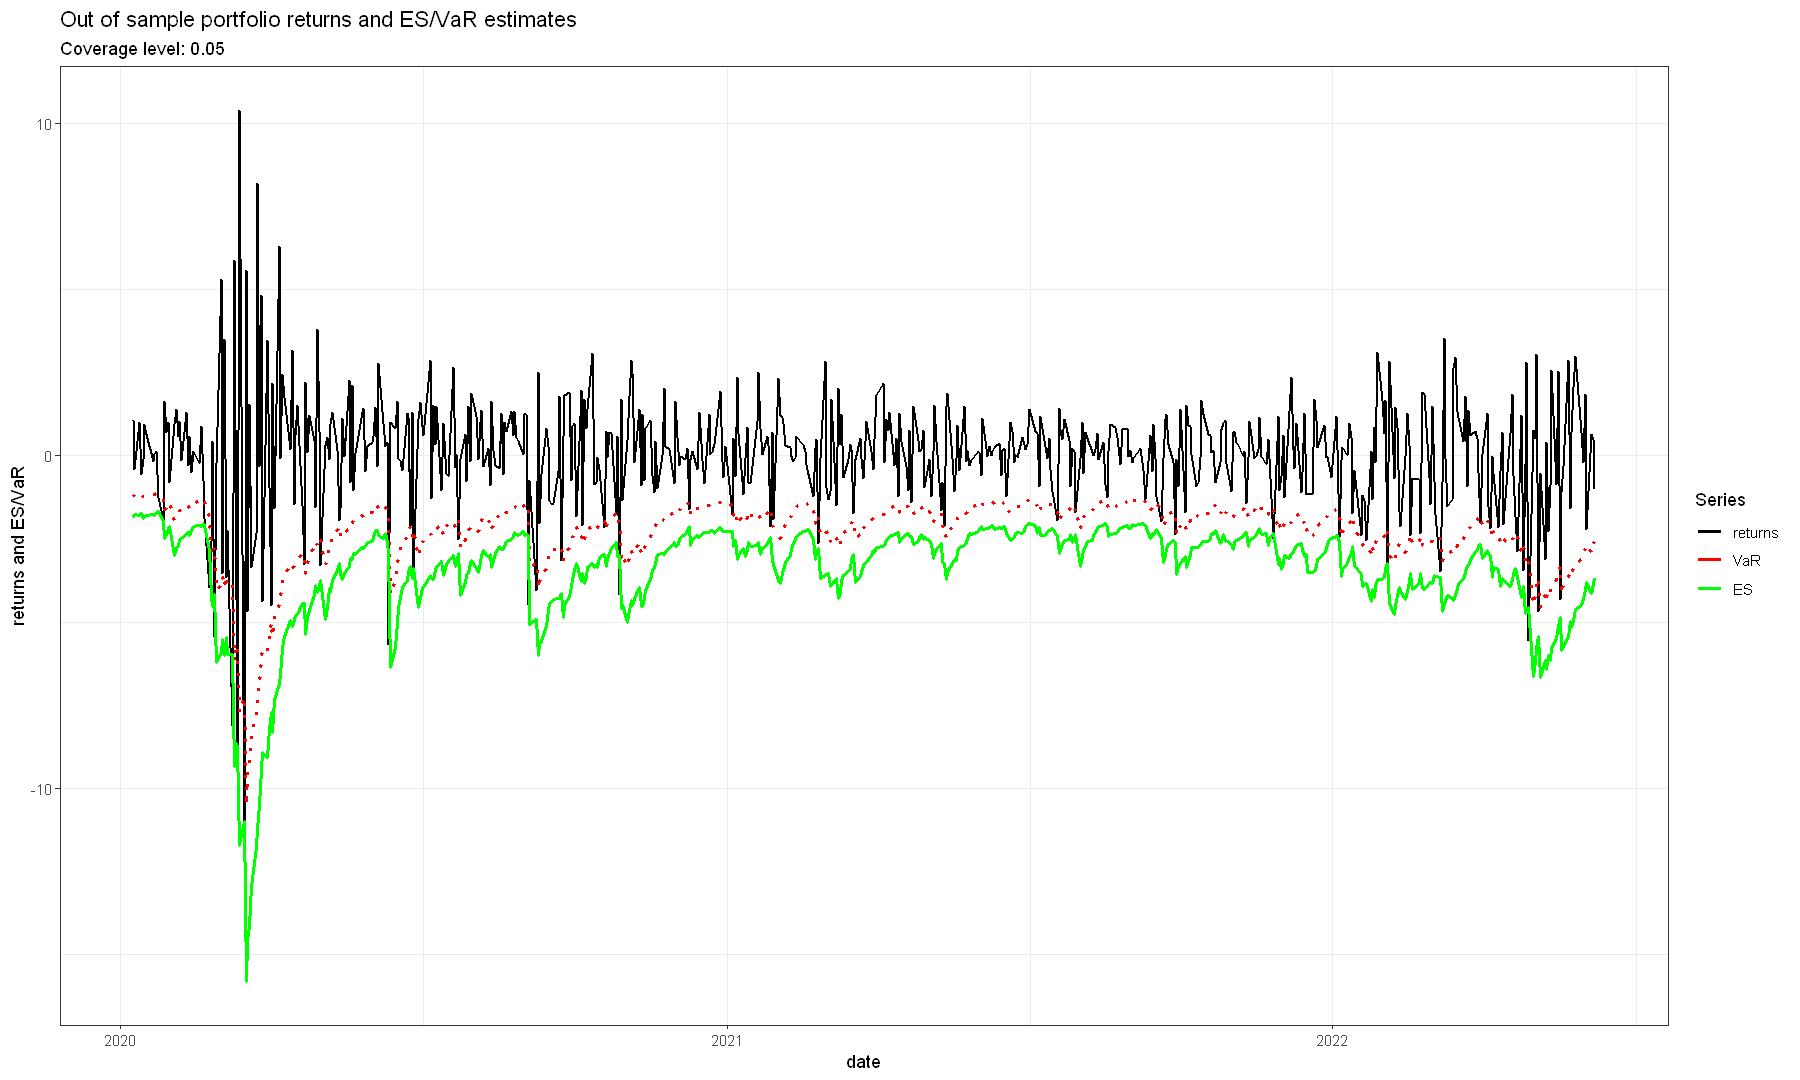

In [49]:
labels <- c("returns" = "black", "VaR" = "red", "ES"="green")
ffigure <- ggplot(OOSdf, aes(x = Date)) +
  geom_line(aes(y = ret, color="returns"), linetype = "solid", size = 0.8) +
  geom_line(aes(y = VaR, color="VaR"), linetype = "dotted", size = 1) +
  geom_line(aes(y = ES, color="ES"), linetype = "solid", size = 1) +
  labs(title = "Out of sample portfolio returns and ES/VaR estimates",
       subtitle = paste0("Coverage level: ", alpha),
       #caption = " ",
       color = "Series",
       x = "date",
       y = "returns and ES/VaR") +
  scale_color_manual(values = labels)
options(repr.plot.width=15, repr.plot.height=9)
ffigure +  theme_bw(base_line_size = 0.1)

The green line in the previous graph represents the expected value of portfolio returns conditioning on returns being lower than their $\alpha$-quantile (i.e., $\mathbb{E}\left(r_{p,t}|r_{p,t}<VaR_{p,t}(\alpha)\right)$). $VaR_{p,t}(\alpha)$  is represented by the red dotted line.

## 4. Backtesting
### 4.1.  Unconditional test of Du & Escanciano (2017)

Du and Escanciano's Expected Shortfall backtests are based on cumulative hits. Denote the *cdf* of $r_{p,t}$ by

$$F(r_{p,t}) = \mathbf{P}(R_{p,t}\leq r_{p,t}).$$ Define $u_{p,t}\equiv F(r_{p,t})$.

$\hat{F}(r_{p,t})$ is obtained by simulation as follows: \begin{equation} \hat{F}(r_{p,t}) = \frac{1}{N}\sum_{j=1}^N\mathbb{I}\left(w_{1}\hat{r}_{1,j} + w_{2}\hat{r}_{2,j} + ... + w_{d}\hat{r}_{d,j} \leq r_{p,t} \right), \end{equation} where the $N$ scenarios of one-day-ahead returns, $\{r_{1,j},...,r_{d,j}\}_{j=1}^N$, are sampled from the multivariate model discussed above, using the estimated parameters fitted on the previous $T_0$ data observations, $\hat{\theta^c}$ and $\hat{\theta}_i$ for $i=1,...,d$, with $N=100,000$.


Then, the cumulative hit is defined as \begin{eqnarray} H_t(\alpha)&=&\int_{0}^{\alpha}h_t(u)du\\
H_t(\alpha)&=& \frac{1}{\alpha}(\alpha-u_t)\mathbb{I}(u_t<\alpha),
\end{eqnarray}
 
Since $h_t(u)$ has mean $u$, by Fubini's theorem, $H_t(\alpha)$ has mean $\frac{\alpha}{2}$. The unconditional backtest for ES is a t-test for the null hypothesis $\mathbb{E}(H_t(\alpha)) = \frac{\alpha}{2}$ and is the analogue for ES of the unconditional VaR backtest proposed in Kupiec (1995).

The t-test statistic is \begin{equation} 
U_{ES}=\frac{\sqrt{n}(\overline{H}(\alpha)-\alpha/2)}{\sqrt{\alpha(1/3 - \alpha/4)}},
\end{equation}

where 
- $n$ is the number of out-of-sample observations 
- $\overline{H}(\alpha)=\frac{1}{n}\sum_{t=1}^n \hat{H}_t(\alpha)$ 
- $\hat{H}_t(\alpha)=\frac{1}{\alpha}(\alpha-\hat{u}_t)\mathbb{I}(\hat{u}_t<\alpha)$.

If the estimation period (**in-sample** lenght) is **larger than** the evaluation period (**out-of-sample** lenght), then $U_{ES}\overset{d}{\sim}N(0,1)$. So that, the null hypothesis of a correctly specified model is rejected at the 5% significance level if the absolute value of the test statistic is greater than 1.96.

In [52]:
# Unconditional test of Du & Escanciano (2017)
# H0: the model is correctly specified
hit <- OOSdf$ret < OOSdf$VaR  
Hit <- (1/alpha)*(alpha-OOSdf$Fret)*(OOSdf$Fret<alpha)
Hbar <- mean(Hit)
Ues <- (sqrt(OOS)*(Hbar-alpha/2))/(sqrt(alpha*(1/3-alpha/4)))
pval <- 2*pnorm(-abs(Ues))
print(data.frame("statistic"=round(Ues,4),"p-value"=round(pval,4),"reject_H0"=abs(Ues)>1.96))

  statistic p.value reject_H0
1    1.5389  0.1238     FALSE


We do not reject the null hypothesis of unconditional coverage with a significance level of 5%.

**References:**
* Cooke, R. and Kurowicka, D. (2006). "Uncertainty Analysis With High Dimensional Dependence Modelling". John Wiley & Sons.
* Czado, C. (2019). "Multivariate Distributions and Copulas". Springer, Cham.
* Hansen, B. E. (1994). “Autoregressive conditional density estimation,” International Economic Review, 705–730.
* Kupiec, P. H. (1995). “Techniques for Verifying the Accuracy of Risk Measurement Models”, The Journal of Derivatives, 3, 73–84.
* Christoffersen, P.F. (1998). "Evaluating interval forecasts", International Economic Review, 39, 841–862.